###Step 1: Verify Python Environment

Before proceeding, Confirm the Python version being used in Google Colab.  
This ensures compatibility with the libraries required for Deep Q-Learning and the Atari Pong environment.






In [1]:
import sys
print(sys.version)

3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


###Step 2: Setting Up the Project Environment

I am setting up the required environment to work with the **Pong** game from the Atari suite.  
This step ensures that the correct versions of all dependencies are installed and compatible for training a Deep Q-Learning (DQN) agent.

####Steps Performed:
1. Uninstall any older or conflicting versions of `gym`, `gymnasium`, `ale-py`, and `AutoROM`.  
2. Install the correct and stable versions of these packages:
   - `gymnasium==0.29.1` → Used to create and manage reinforcement learning environments.  
   - `ale-py==0.10.1` → Backend for Atari Learning Environment (ALE).  
   - `AutoROM==0.6.1` → Automatically downloads and installs Atari ROMs required for games like Pong.  
3. Accept the Atari ROM license automatically using the `--accept-license` flag.

This setup ensures that the **ALE/Pong-v5** environment can be loaded successfully for training the DQN agent.


In [2]:
!pip uninstall -y gym gymnasium ale-py autorom
!pip install gymnasium==0.29.1 ale-py==0.10.1 AutoROM==0.6.1
!AutoROM --accept-license

Found existing installation: gym 0.25.2
Uninstalling gym-0.25.2:
  Successfully uninstalled gym-0.25.2
Found existing installation: gymnasium 1.2.2
Uninstalling gymnasium-1.2.2:
  Successfully uninstalled gymnasium-1.2.2
Found existing installation: ale-py 0.11.2
Uninstalling ale-py-0.11.2:
  Successfully uninstalled ale-py-0.11.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 64.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gym<=0.25.2, which is not installed.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.1 which is incompatible.
AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.12/dist-packages/AutoROM/roms

Existing ROMs will be overwritten.
Installed /u

In [3]:
!pip show autorom
!AutoROM --accept-license

Name: AutoROM
Version: 0.6.1
Summary: Automated installation of Atari ROMs for Gym/ALE-Py
Home-page: https://github.com/Farama-Foundation/AutoROM
Author: Farama Foundation
Author-email: contact@farama.org
License: MIT
Location: /usr/local/lib/python3.12/dist-packages
Requires: click, requests
Required-by: 
AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.12/dist-packages/AutoROM/roms

Existing ROMs will be overwritten.


In [4]:
!pip install torch torchvision torchaudio matplotlib opencv-python tqdm pandas seaborn

In [5]:
import gymnasium as gym
import ale_py

env = gym.make("ALE/Pong-v5", render_mode="rgb_array")
obs, info = env.reset()
print("Pong environment loaded successfully!")
env.close()

Pong environment loaded successfully!


###Step 3: Importing Required Libraries and Setting Up the Environment

In this step, I am importing all the essential libraries required for implementing and training the **Deep Q-Network (DQN)** on the Pong environment.  

####Libraries Used:
- **os, random, time, collections:** General-purpose Python modules for managing files, randomness, and data structures.  
- **numpy & pandas:** For numerical computation and data analysis.  
- **matplotlib & seaborn:** For visualizing training metrics such as rewards and losses.  
- **gymnasium:** To create and interact with the Pong environment.  
- **torch (PyTorch):** For building and training the deep neural network used as the Q-function approximator.  
- **tqdm:** To display progress bars during training for better tracking.

####Additional Setup:
- A fixed **random seed (42)** is set for reproducibility, ensuring consistent results across runs.  
- The code automatically checks for GPU availability using `torch.cuda.is_available()` to speed up training.  
- The chosen device (CPU or GPU) is displayed for confirmation.

This initialization step ensures the environment is ready for defining and training the Deep Q-Learning agent.


In [6]:
#Importing necessary libraries
import os
import random
import time
from collections import deque, namedtuple
from typing import Tuple, List, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange, tqdm

import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# reproducibility helper
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


### Step 4: Frame Preprocessing

This section handles the preprocessing of Pong game frames before they are used for training.  
The preprocessing steps reduce the image complexity and highlight the essential gameplay areas.

**Steps performed:**
1. Convert the frame from RGB to grayscale to reduce computation.
2. Crop the frame to remove unnecessary parts like the scoreboard.
3. Resize the frame to 84×80 pixels.
4. Normalize pixel values to the range [0,1].
5. Stack the latest 4 frames to capture motion information for the model.


In [7]:
# Preprocessing
import cv2

def preprocess_frame(frame: np.ndarray, crop: bool = True) -> np.ndarray:
    """
    Convert RGB frame to grayscale, crop (if needed), resize to 84x80.
    Returns float32 array in [0,1] with shape (84,80).
    """
    # frame comes in RGB
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Crop to play area similar to Atari preprocessing (if recommended)
    # The original Atari frame is 210x160. A common crop: remove score area.
    if crop:
        # Crop rows 34:194 (same common approach), keeps width 160
        cropped = gray[34:194, :]
    else:
        cropped = gray

    # Resize to (80 width x 84 height) -> shape (84, 80)
    resized = cv2.resize(cropped, (80, 84), interpolation=cv2.INTER_AREA)
    # normalize
    return (resized.astype(np.float32) / 255.0)

def stack_frames(frames: deque) -> np.ndarray:
    """
    Given deque of 4 frames (each (84,80)), stack to (4,84,80)
    """
    return np.stack(list(frames), axis=0).astype(np.float32)

### Step 5: Replay Memory

Replay Memory is used to store past game experiences, which helps the agent learn more effectively.  
Each experience (called a **transition**) includes:
- **state** → current observation  
- **action** → move taken by the agent  
- **reward** → feedback received  
- **next_state** → next observation after the action  
- **done** → whether the episode has ended  

By sampling random batches from memory during training, the agent avoids learning from highly correlated data and improves stability.


In [8]:
#Replay memory
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayMemory:
    def __init__(self, capacity: int):
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        self.buffer.append(Transition(*args))

    def sample(self, batch_size: int) -> List[Transition]:
        return random.sample(self.buffer, batch_size)

    def __len__(self) -> int:
        return len(self.buffer)

### Step 6: Deep Q-Network (DQN)

This network is designed to predict the Q-values for each possible action given a game state.  
It processes stacked game frames (4 frames) using convolutional layers to capture spatial and temporal information.

**Architecture Overview:**
- **Input:** 4 grayscale frames of size (84 × 80)
- **Conv1:** 32 filters, kernel 8×8, stride 4  
- **Conv2:** 64 filters, kernel 4×4, stride 2  
- **Conv3:** 64 filters, kernel 3×3, stride 1  
- **FC1:** Fully connected layer with 512 units  
- **Output:** One Q-value for each possible action  

**Purpose:**  
The DQN predicts how valuable each action is in the current state, helping the agent choose the best move.


In [9]:
# DQN network
class DQN(nn.Module):
    def __init__(self, n_actions: int):
        super().__init__()
        # Input shape: (batch, 4, 84, 80)
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)  # -> approx (32,20,19)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2) # -> approx (64,9,8)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1) # -> approx (64,7,6)

        # compute flattened feature size dynamically
        self._to_linear = 64 * 7 * 6  # based on above dims for 84x80 input
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.out = nn.Linear(512, n_actions)

    def forward(self, x):
        # x: (batch, 4, 84, 80)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.out(x)

### Step 7: DQN Agent Implementation

This class defines the **DQN Agent**, which interacts with the environment, stores experiences, and learns optimal actions.

**Key Components:**
- **Policy Network:** Learns to predict Q-values for each action.  
- **Target Network:** Provides stable target values for training.  
- **Replay Memory:** Stores past experiences `(state, action, reward, next_state, done)` for training.  
- **Optimizer:** Uses Adam to minimize the Q-learning loss.

**Main Functions:**
- `select_action(state)`: Chooses an action using the epsilon-greedy policy (balances exploration and exploitation).  
- `store(...)`: Saves an experience in replay memory.  
- `update_epsilon()`: Gradually reduces exploration rate (epsilon decay).  
- `optimize()`: Samples a batch from memory, computes the Q-learning loss, and updates the network weights.

**Purpose:**  
The agent learns by interacting with the environment — exploring actions, receiving rewards, and improving its policy over time.


In [10]:
# Agent implementation
class DQNAgent:
    def __init__(self,
                 n_actions: int,
                 lr: float = 1e-4,
                 batch_size: int = 8,
                 gamma: float = 0.95,
                 epsilon_init: float = 1.0,
                 epsilon_decay: float = 0.995,
                 epsilon_min: float = 0.05,
                 memory_capacity: int = 50000,
                 target_update_episodes: int = 10):
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon_init
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.target_update_episodes = target_update_episodes

        self.policy_net = DQN(n_actions).to(device)
        self.target_net = DQN(n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.memory = ReplayMemory(memory_capacity)
        self.learn_steps = 0

    def select_action(self, state: np.ndarray) -> int:
        """state shape: (4,84,80)"""
        if random.random() < self.epsilon:
            return random.randrange(self.n_actions)
        state_t = torch.from_numpy(state).unsqueeze(0).to(device)  # (1,4,84,80)
        with torch.no_grad():
            qvals = self.policy_net(state_t)
            return int(torch.argmax(qvals, dim=1).item())

    def store(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

    def update_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            if self.epsilon < self.epsilon_min:
                self.epsilon = self.epsilon_min

    def optimize(self):
        if len(self.memory) < self.batch_size:
            return None

        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        state_batch = torch.from_numpy(np.array(batch.state)).to(device)         # (B,4,84,80)
        action_batch = torch.tensor(batch.action, dtype=torch.long).unsqueeze(1).to(device) # (B,1)
        reward_batch = torch.tensor(batch.reward, dtype=torch.float32).to(device)           # (B,)
        next_state_batch = torch.from_numpy(np.array(batch.next_state)).to(device)
        done_batch = torch.tensor(batch.done, dtype=torch.float32).to(device)

        # Q(s,a)
        q_values = self.policy_net(state_batch).gather(1, action_batch).squeeze(1)  # (B,)

        # target: r + gamma * max_a' Q_target(s', a') * (1 - done)
        with torch.no_grad():
            next_q = self.target_net(next_state_batch).max(1)[0]
            target_q = reward_batch + self.gamma * next_q * (1.0 - done_batch)

        loss = F.mse_loss(q_values, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        # gradient clipping for stability
        nn.utils.clip_grad_norm_(self.policy_net.parameters(), 10)
        self.optimizer.step()

        self.learn_steps += 1
        return loss.item()

### Step 8: Training the DQN Agent

This part trains the DQN agent in the game environment.

- The agent plays several episodes.
- It learns by storing experiences and improving from them.
- The epsilon value controls how often it explores new actions.
- The target network is updated regularly for stable learning.
- At the end, results are saved as a CSV file and model weights are stored.

The function returns a DataFrame with episode results like score, average reward, epsilon, and loss.


In [11]:
# Training loop
def train_dqn(env_id: str,
              num_episodes: int = 300,
              batch_size: int = 8,
              target_update_episodes: int = 10,
              memory_capacity: int = 50000,
              render: bool = False,
              save_dir: str = "./runs",
              seed: int = SEED) -> pd.DataFrame:
    """
    Trains DQN and returns DataFrame with per-episode metrics:
    columns: ['episode', 'score', 'avg_reward_5', 'epsilon', 'steps', 'loss']
    """
    os.makedirs(save_dir, exist_ok=True)
    env = gym.make(env_id, render_mode=None)  # render_mode=None for headless
    env.reset(seed=seed)
    n_actions = env.action_space.n
    agent = DQNAgent(n_actions,
                     batch_size=batch_size,
                     memory_capacity=memory_capacity,
                     target_update_episodes=target_update_episodes)

    scores = []
    avg5_list = []
    eps_list = []
    steps_list = []
    loss_list = []

    for ep in trange(num_episodes, desc="Episodes"):
        obs, info = env.reset()
        frame = preprocess_frame(obs)
        frames = deque(maxlen=4)
        for _ in range(4):
            frames.append(frame)
        state = stack_frames(frames)  # (4,84,80)
        done = False
        ep_reward = 0.0
        step_count = 0
        ep_losses = []

        while not done:
            action = agent.select_action(state)
            next_obs, reward, terminated, truncated, info = env.step(action)
            done = bool(terminated or truncated)
            next_frame = preprocess_frame(next_obs)
            frames.append(next_frame)
            next_state = stack_frames(frames)

            agent.store(state, action, reward, next_state, done)
            loss_val = agent.optimize()
            if loss_val is not None:
                ep_losses.append(loss_val)

            state = next_state
            ep_reward += reward
            step_count += 1

            if render:
                env.render()

        # end episode
        agent.update_epsilon()

        # update target network every target_update_episodes (episodes)
        if (ep + 1) % agent.target_update_episodes == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())

        scores.append(ep_reward)
        avg5 = float(np.mean(scores[-5:])) if len(scores) >= 1 else float(ep_reward)
        avg5_list.append(avg5)
        eps_list.append(agent.epsilon)
        steps_list.append(step_count)
        loss_list.append(float(np.mean(ep_losses)) if ep_losses else None)

        # print summary every 10 episodes
        if (ep + 1) % 10 == 0 or ep == 0:
            print(f"Ep {ep+1}/{num_episodes} | Score: {ep_reward:.1f} | Avg5: {avg5:.2f} | Eps: {agent.epsilon:.3f} | Steps: {step_count} | Loss: {loss_list[-1]}")

    env.close()
    df = pd.DataFrame({
        "episode": np.arange(1, len(scores)+1),
        "score": scores,
        "avg_reward_5": avg5_list,
        "epsilon": eps_list,
        "steps": steps_list,
        "loss": loss_list
    })
    # Save results
    run_name = f"run_bs{batch_size}_tgt{target_update_episodes}_{int(time.time())}"
    df.to_csv(os.path.join(save_dir, run_name + ".csv"), index=False)
    # Save model (final policy)
    torch.save(agent.policy_net.state_dict(), os.path.join(save_dir, run_name + "_policy.pt"))
    torch.save(agent.target_net.state_dict(), os.path.join(save_dir, run_name + "_target.pt"))

    return df

### Step 9: Visualizing Training Results

This function plots the agent’s performance over episodes.  
It shows the reward per episode and the moving average of the last 5 episodes to visualize learning progress.


In [12]:
# Plotting Utilities
def plot_training(df: pd.DataFrame, title: str = "Training"):
    plt.figure(figsize=(12,5))
    plt.plot(df['episode'], df['score'], label='Score per Episode', alpha=0.7)
    plt.plot(df['episode'], df['avg_reward_5'], label='Avg (last 5)', linewidth=2)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

### Step 10: Train and Evaluate the DQN Agent

In this step, the Pong environment is loaded, and the DQN training process begins.  
The model is trained for 300 episodes, and training results are visualized using the plot function.


Episodes:   0%|          | 1/300 [00:06<33:59,  6.82s/it]

Ep 1/300 | Score: -20.0 | Avg5: -20.00 | Eps: 0.995 | Steps: 1083 | Loss: 0.011000192518033662


Episodes:   3%|▎         | 10/300 [00:52<24:54,  5.16s/it]

Ep 10/300 | Score: -21.0 | Avg5: -19.80 | Eps: 0.951 | Steps: 903 | Loss: 0.020678807058691843


Episodes:   7%|▋         | 20/300 [01:42<23:28,  5.03s/it]

Ep 20/300 | Score: -21.0 | Avg5: -20.60 | Eps: 0.905 | Steps: 904 | Loss: 0.022075220843563545


Episodes:  10%|█         | 30/300 [02:30<20:15,  4.50s/it]

Ep 30/300 | Score: -21.0 | Avg5: -20.60 | Eps: 0.860 | Steps: 764 | Loss: 0.023112795116184512


Episodes:  13%|█▎        | 40/300 [03:18<19:36,  4.53s/it]

Ep 40/300 | Score: -21.0 | Avg5: -20.80 | Eps: 0.818 | Steps: 792 | Loss: 0.02467926682834102


Episodes:  17%|█▋        | 50/300 [04:06<19:14,  4.62s/it]

Ep 50/300 | Score: -21.0 | Avg5: -20.60 | Eps: 0.778 | Steps: 824 | Loss: 0.023514263374733488


Episodes:  20%|██        | 60/300 [04:56<20:35,  5.15s/it]

Ep 60/300 | Score: -19.0 | Avg5: -19.60 | Eps: 0.740 | Steps: 998 | Loss: 0.02275164394779061


Episodes:  23%|██▎       | 70/300 [05:39<17:00,  4.44s/it]

Ep 70/300 | Score: -20.0 | Avg5: -20.40 | Eps: 0.704 | Steps: 889 | Loss: 0.022372179029625187


Episodes:  27%|██▋       | 80/300 [06:27<19:02,  5.19s/it]

Ep 80/300 | Score: -19.0 | Avg5: -20.20 | Eps: 0.670 | Steps: 1089 | Loss: 0.022950812451435806


Episodes:  30%|███       | 90/300 [07:15<16:05,  4.60s/it]

Ep 90/300 | Score: -21.0 | Avg5: -20.60 | Eps: 0.637 | Steps: 764 | Loss: 0.021307834923986274


Episodes:  33%|███▎      | 100/300 [08:02<15:35,  4.68s/it]

Ep 100/300 | Score: -21.0 | Avg5: -20.60 | Eps: 0.606 | Steps: 821 | Loss: 0.02512051239621771


Episodes:  37%|███▋      | 110/300 [08:49<15:36,  4.93s/it]

Ep 110/300 | Score: -20.0 | Avg5: -20.00 | Eps: 0.576 | Steps: 842 | Loss: 0.02482208324698737


Episodes:  40%|████      | 120/300 [09:36<13:53,  4.63s/it]

Ep 120/300 | Score: -20.0 | Avg5: -20.40 | Eps: 0.548 | Steps: 842 | Loss: 0.02249411620048147


Episodes:  43%|████▎     | 130/300 [10:21<12:59,  4.58s/it]

Ep 130/300 | Score: -21.0 | Avg5: -21.00 | Eps: 0.521 | Steps: 826 | Loss: 0.021457498885601528


Episodes:  47%|████▋     | 140/300 [11:08<12:52,  4.83s/it]

Ep 140/300 | Score: -21.0 | Avg5: -20.80 | Eps: 0.496 | Steps: 886 | Loss: 0.02546156847429158


Episodes:  50%|█████     | 150/300 [11:55<11:49,  4.73s/it]

Ep 150/300 | Score: -21.0 | Avg5: -20.80 | Eps: 0.471 | Steps: 882 | Loss: 0.025415628967722752


Episodes:  53%|█████▎    | 160/300 [12:42<10:59,  4.71s/it]

Ep 160/300 | Score: -21.0 | Avg5: -21.00 | Eps: 0.448 | Steps: 783 | Loss: 0.023815741225231692


Episodes:  57%|█████▋    | 170/300 [13:26<09:25,  4.35s/it]

Ep 170/300 | Score: -21.0 | Avg5: -20.80 | Eps: 0.427 | Steps: 823 | Loss: 0.024835740664091475


Episodes:  60%|██████    | 180/300 [14:13<09:42,  4.85s/it]

Ep 180/300 | Score: -21.0 | Avg5: -20.40 | Eps: 0.406 | Steps: 884 | Loss: 0.025673816859298353


Episodes:  63%|██████▎   | 190/300 [15:01<08:28,  4.62s/it]

Ep 190/300 | Score: -21.0 | Avg5: -20.20 | Eps: 0.386 | Steps: 764 | Loss: 0.024281595755849674


Episodes:  67%|██████▋   | 200/300 [15:48<07:46,  4.67s/it]

Ep 200/300 | Score: -21.0 | Avg5: -20.60 | Eps: 0.367 | Steps: 824 | Loss: 0.01964357437192094


Episodes:  70%|███████   | 210/300 [16:34<06:53,  4.60s/it]

Ep 210/300 | Score: -21.0 | Avg5: -20.80 | Eps: 0.349 | Steps: 854 | Loss: 0.024089165422392013


Episodes:  73%|███████▎  | 220/300 [17:24<06:38,  4.98s/it]

Ep 220/300 | Score: -21.0 | Avg5: -20.40 | Eps: 0.332 | Steps: 949 | Loss: 0.025473423205493083


Episodes:  77%|███████▋  | 230/300 [18:10<05:22,  4.61s/it]

Ep 230/300 | Score: -20.0 | Avg5: -20.80 | Eps: 0.316 | Steps: 842 | Loss: 0.023537253528661116


Episodes:  80%|████████  | 240/300 [18:57<04:58,  4.97s/it]

Ep 240/300 | Score: -19.0 | Avg5: -20.60 | Eps: 0.300 | Steps: 922 | Loss: 0.02356512454763755


Episodes:  83%|████████▎ | 250/300 [19:45<03:56,  4.73s/it]

Ep 250/300 | Score: -21.0 | Avg5: -20.60 | Eps: 0.286 | Steps: 824 | Loss: 0.024027198618427666


Episodes:  87%|████████▋ | 260/300 [20:33<03:12,  4.80s/it]

Ep 260/300 | Score: -21.0 | Avg5: -20.40 | Eps: 0.272 | Steps: 764 | Loss: 0.021163498411034


Episodes:  90%|█████████ | 270/300 [21:20<02:26,  4.89s/it]

Ep 270/300 | Score: -21.0 | Avg5: -20.80 | Eps: 0.258 | Steps: 825 | Loss: 0.023443114341053208


Episodes:  93%|█████████▎| 280/300 [22:07<01:37,  4.86s/it]

Ep 280/300 | Score: -20.0 | Avg5: -20.40 | Eps: 0.246 | Steps: 842 | Loss: 0.020261128827367605


Episodes:  97%|█████████▋| 290/300 [22:56<00:48,  4.82s/it]

Ep 290/300 | Score: -21.0 | Avg5: -21.00 | Eps: 0.234 | Steps: 824 | Loss: 0.022817849903395717


Episodes: 100%|██████████| 300/300 [23:43<00:00,  4.75s/it]

Ep 300/300 | Score: -20.0 | Avg5: -20.60 | Eps: 0.222 | Steps: 838 | Loss: 0.026023437344292147


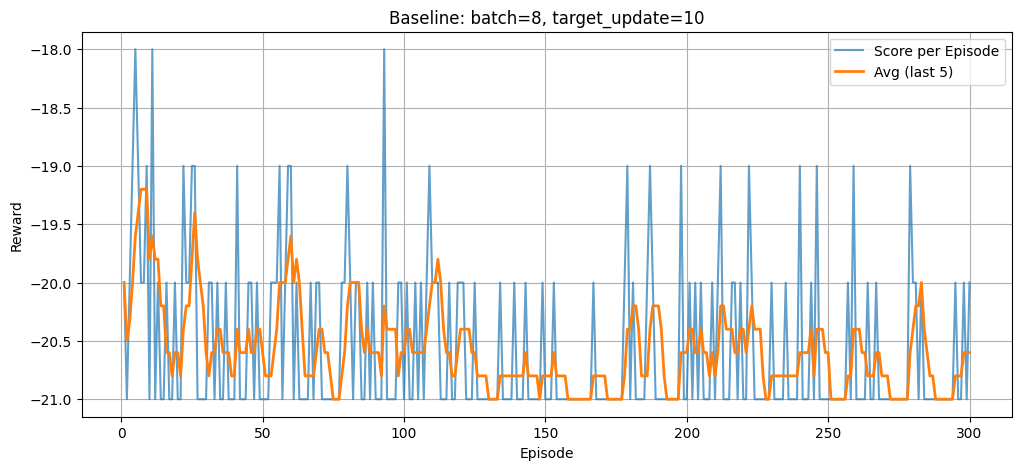

In [13]:
# Train DQN Agent
env_id = "ALE/Pong-v5"   # or "ALE/Pong-v5" if gymnasium resolves that.
baseline_df = train_dqn(env_id, num_episodes=300, batch_size=8, target_update_episodes=10, save_dir="./runs")
plot_training(baseline_df, title="Baseline: batch=8, target_update=10")

### Step 11: Compare Training with Different Batch Sizes

In this step, the DQN agent is trained twice using different batch sizes (8 and 16).  
This helps analyze how batch size affects the learning stability and performance of the model.  
The training progress for each batch size is plotted for comparison.


Episodes:   0%|          | 1/300 [00:03<19:43,  3.96s/it]

Ep 1/300 | Score: -21.0 | Avg5: -21.00 | Eps: 0.995 | Steps: 825 | Loss: 0.021578449675882645


Episodes:   3%|▎         | 10/300 [00:49<23:40,  4.90s/it]

Ep 10/300 | Score: -19.0 | Avg5: -19.40 | Eps: 0.951 | Steps: 974 | Loss: 0.022619652643313205


Episodes:   7%|▋         | 20/300 [01:37<22:44,  4.87s/it]

Ep 20/300 | Score: -19.0 | Avg5: -20.00 | Eps: 0.905 | Steps: 1045 | Loss: 0.021434286284276047


Episodes:  10%|█         | 30/300 [02:24<21:33,  4.79s/it]

Ep 30/300 | Score: -19.0 | Avg5: -20.20 | Eps: 0.860 | Steps: 982 | Loss: 0.022732687431425893


Episodes:  13%|█▎        | 40/300 [03:13<20:21,  4.70s/it]

Ep 40/300 | Score: -20.0 | Avg5: -20.80 | Eps: 0.818 | Steps: 950 | Loss: 0.0217808502275607


Episodes:  17%|█▋        | 50/300 [04:00<19:50,  4.76s/it]

Ep 50/300 | Score: -21.0 | Avg5: -20.60 | Eps: 0.778 | Steps: 824 | Loss: 0.02347910268743592


Episodes:  20%|██        | 60/300 [04:50<19:15,  4.81s/it]

Ep 60/300 | Score: -21.0 | Avg5: -20.80 | Eps: 0.740 | Steps: 884 | Loss: 0.02424293393875621


Episodes:  23%|██▎       | 70/300 [05:41<19:22,  5.05s/it]

Ep 70/300 | Score: -20.0 | Avg5: -19.40 | Eps: 0.704 | Steps: 872 | Loss: 0.02145549375545503


Episodes:  27%|██▋       | 80/300 [06:25<16:09,  4.41s/it]

Ep 80/300 | Score: -21.0 | Avg5: -21.00 | Eps: 0.670 | Steps: 852 | Loss: 0.021892768404144027


Episodes:  30%|███       | 90/300 [07:13<17:24,  4.97s/it]

Ep 90/300 | Score: -20.0 | Avg5: -20.20 | Eps: 0.637 | Steps: 842 | Loss: 0.023499698140164848


Episodes:  33%|███▎      | 100/300 [08:01<15:49,  4.75s/it]

Ep 100/300 | Score: -20.0 | Avg5: -19.80 | Eps: 0.606 | Steps: 860 | Loss: 0.023886141634470413


Episodes:  37%|███▋      | 110/300 [08:48<14:25,  4.55s/it]

Ep 110/300 | Score: -21.0 | Avg5: -21.00 | Eps: 0.576 | Steps: 824 | Loss: 0.02258555975464174


Episodes:  40%|████      | 120/300 [09:33<13:13,  4.41s/it]

Ep 120/300 | Score: -21.0 | Avg5: -20.60 | Eps: 0.548 | Steps: 764 | Loss: 0.02063508861124438


Episodes:  43%|████▎     | 130/300 [10:20<12:40,  4.47s/it]

Ep 130/300 | Score: -21.0 | Avg5: -20.60 | Eps: 0.521 | Steps: 792 | Loss: 0.023964388483951975


Episodes:  47%|████▋     | 140/300 [11:04<11:31,  4.32s/it]

Ep 140/300 | Score: -21.0 | Avg5: -20.80 | Eps: 0.496 | Steps: 793 | Loss: 0.022750234456384504


Episodes:  50%|█████     | 150/300 [11:49<10:55,  4.37s/it]

Ep 150/300 | Score: -21.0 | Avg5: -21.00 | Eps: 0.471 | Steps: 764 | Loss: 0.024016848659031313


Episodes:  53%|█████▎    | 160/300 [12:33<10:18,  4.42s/it]

Ep 160/300 | Score: -21.0 | Avg5: -21.00 | Eps: 0.448 | Steps: 826 | Loss: 0.022549822893224547


Episodes:  57%|█████▋    | 170/300 [13:19<10:01,  4.63s/it]

Ep 170/300 | Score: -21.0 | Avg5: -20.20 | Eps: 0.427 | Steps: 912 | Loss: 0.02071438809862389


Episodes:  60%|██████    | 180/300 [14:08<09:33,  4.78s/it]

Ep 180/300 | Score: -21.0 | Avg5: -20.40 | Eps: 0.406 | Steps: 764 | Loss: 0.022043950474925102


Episodes:  63%|██████▎   | 190/300 [14:54<08:52,  4.84s/it]

Ep 190/300 | Score: -20.0 | Avg5: -20.60 | Eps: 0.386 | Steps: 1024 | Loss: 0.024223724277078418


Episodes:  67%|██████▋   | 200/300 [15:40<07:30,  4.51s/it]

Ep 200/300 | Score: -20.0 | Avg5: -20.80 | Eps: 0.367 | Steps: 866 | Loss: 0.02468836238224239


Episodes:  70%|███████   | 210/300 [16:28<07:20,  4.90s/it]

Ep 210/300 | Score: -21.0 | Avg5: -20.00 | Eps: 0.349 | Steps: 948 | Loss: 0.02347454432020652


Episodes:  73%|███████▎  | 220/300 [17:13<05:53,  4.42s/it]

Ep 220/300 | Score: -21.0 | Avg5: -20.60 | Eps: 0.332 | Steps: 824 | Loss: 0.02828984617633413


Episodes:  77%|███████▋  | 230/300 [17:58<05:10,  4.44s/it]

Ep 230/300 | Score: -21.0 | Avg5: -20.80 | Eps: 0.316 | Steps: 764 | Loss: 0.026610521331506584


Episodes:  80%|████████  | 240/300 [18:43<04:27,  4.46s/it]

Ep 240/300 | Score: -20.0 | Avg5: -20.80 | Eps: 0.300 | Steps: 843 | Loss: 0.02753488897203859


Episodes:  83%|████████▎ | 250/300 [19:32<04:12,  5.06s/it]

Ep 250/300 | Score: -20.0 | Avg5: -20.20 | Eps: 0.286 | Steps: 943 | Loss: 0.025364172542108467


Episodes:  87%|████████▋ | 260/300 [20:19<03:10,  4.76s/it]

Ep 260/300 | Score: -20.0 | Avg5: -20.20 | Eps: 0.272 | Steps: 870 | Loss: 0.020986868907468682


Episodes:  90%|█████████ | 270/300 [21:06<02:21,  4.71s/it]

Ep 270/300 | Score: -20.0 | Avg5: -20.60 | Eps: 0.258 | Steps: 921 | Loss: 0.02231247917861232


Episodes:  93%|█████████▎| 280/300 [21:52<01:35,  4.79s/it]

Ep 280/300 | Score: -18.0 | Avg5: -20.40 | Eps: 0.246 | Steps: 1032 | Loss: 0.021874125627837485


Episodes:  97%|█████████▋| 290/300 [22:35<00:42,  4.27s/it]

Ep 290/300 | Score: -21.0 | Avg5: -21.00 | Eps: 0.234 | Steps: 794 | Loss: 0.023464522066013536


Episodes: 100%|██████████| 300/300 [23:20<00:00,  4.67s/it]

Ep 300/300 | Score: -20.0 | Avg5: -20.60 | Eps: 0.222 | Steps: 843 | Loss: 0.026213344522809316



Episodes:   0%|          | 1/300 [00:04<22:42,  4.56s/it]

Ep 1/300 | Score: -21.0 | Avg5: -21.00 | Eps: 0.995 | Steps: 783 | Loss: 0.020582489617230488


Episodes:   3%|▎         | 10/300 [00:52<25:10,  5.21s/it]

Ep 10/300 | Score: -21.0 | Avg5: -20.20 | Eps: 0.951 | Steps: 811 | Loss: 0.023045369941909463


Episodes:   7%|▋         | 20/300 [01:45<23:22,  5.01s/it]

Ep 20/300 | Score: -21.0 | Avg5: -20.60 | Eps: 0.905 | Steps: 946 | Loss: 0.024031485008244674


Episodes:  10%|█         | 30/300 [02:41<26:28,  5.88s/it]

Ep 30/300 | Score: -19.0 | Avg5: -19.80 | Eps: 0.860 | Steps: 1008 | Loss: 0.02367442078921447


Episodes:  13%|█▎        | 40/300 [03:32<23:06,  5.33s/it]

Ep 40/300 | Score: -20.0 | Avg5: -20.60 | Eps: 0.818 | Steps: 987 | Loss: 0.023018529460958385


Episodes:  17%|█▋        | 50/300 [04:23<21:18,  5.11s/it]

Ep 50/300 | Score: -21.0 | Avg5: -20.80 | Eps: 0.778 | Steps: 824 | Loss: 0.02450486942671507


Episodes:  20%|██        | 60/300 [05:15<20:40,  5.17s/it]

Ep 60/300 | Score: -21.0 | Avg5: -21.00 | Eps: 0.740 | Steps: 913 | Loss: 0.02180153245213064


Episodes:  23%|██▎       | 70/300 [06:10<21:30,  5.61s/it]

Ep 70/300 | Score: -21.0 | Avg5: -20.80 | Eps: 0.704 | Steps: 1012 | Loss: 0.024755055912932068


Episodes:  27%|██▋       | 80/300 [07:04<19:05,  5.21s/it]

Ep 80/300 | Score: -21.0 | Avg5: -20.00 | Eps: 0.670 | Steps: 783 | Loss: 0.022337094382976156


Episodes:  30%|███       | 90/300 [07:57<18:01,  5.15s/it]

Ep 90/300 | Score: -20.0 | Avg5: -20.60 | Eps: 0.637 | Steps: 842 | Loss: 0.026120730328342917


Episodes:  33%|███▎      | 100/300 [08:49<17:22,  5.21s/it]

Ep 100/300 | Score: -21.0 | Avg5: -20.40 | Eps: 0.606 | Steps: 873 | Loss: 0.02620321378984754


Episodes:  37%|███▋      | 110/300 [09:42<16:21,  5.17s/it]

Ep 110/300 | Score: -21.0 | Avg5: -20.40 | Eps: 0.576 | Steps: 880 | Loss: 0.023653488047784776


Episodes:  40%|████      | 120/300 [10:32<14:50,  4.95s/it]

Ep 120/300 | Score: -20.0 | Avg5: -20.60 | Eps: 0.548 | Steps: 842 | Loss: 0.023200249394824016


Episodes:  43%|████▎     | 130/300 [11:24<14:32,  5.13s/it]

Ep 130/300 | Score: -21.0 | Avg5: -20.80 | Eps: 0.521 | Steps: 843 | Loss: 0.026557850415263522


Episodes:  47%|████▋     | 140/300 [12:16<13:30,  5.06s/it]

Ep 140/300 | Score: -20.0 | Avg5: -20.40 | Eps: 0.496 | Steps: 842 | Loss: 0.023377568063571177


Episodes:  50%|█████     | 150/300 [13:08<12:50,  5.13s/it]

Ep 150/300 | Score: -21.0 | Avg5: -20.80 | Eps: 0.471 | Steps: 826 | Loss: 0.024614526737123655


Episodes:  53%|█████▎    | 160/300 [13:58<12:12,  5.23s/it]

Ep 160/300 | Score: -21.0 | Avg5: -20.60 | Eps: 0.448 | Steps: 826 | Loss: 0.02283070508279887


Episodes:  57%|█████▋    | 170/300 [14:51<11:21,  5.25s/it]

Ep 170/300 | Score: -21.0 | Avg5: -20.80 | Eps: 0.427 | Steps: 886 | Loss: 0.024420918987029333


Episodes:  60%|██████    | 180/300 [15:46<10:39,  5.33s/it]

Ep 180/300 | Score: -21.0 | Avg5: -20.60 | Eps: 0.406 | Steps: 793 | Loss: 0.02527213742026371


Episodes:  63%|██████▎   | 190/300 [16:40<09:40,  5.28s/it]

Ep 190/300 | Score: -20.0 | Avg5: -20.60 | Eps: 0.386 | Steps: 838 | Loss: 0.02205064470409071


Episodes:  67%|██████▋   | 200/300 [17:34<09:11,  5.52s/it]

Ep 200/300 | Score: -20.0 | Avg5: -20.00 | Eps: 0.367 | Steps: 842 | Loss: 0.02194894854892698


Episodes:  70%|███████   | 210/300 [18:24<07:48,  5.21s/it]

Ep 210/300 | Score: -21.0 | Avg5: -20.80 | Eps: 0.349 | Steps: 887 | Loss: 0.02436259510969426


Episodes:  73%|███████▎  | 220/300 [19:17<06:59,  5.24s/it]

Ep 220/300 | Score: -21.0 | Avg5: -20.20 | Eps: 0.332 | Steps: 783 | Loss: 0.02410699960735233


Episodes:  77%|███████▋  | 230/300 [20:07<05:50,  5.00s/it]

Ep 230/300 | Score: -21.0 | Avg5: -20.80 | Eps: 0.316 | Steps: 764 | Loss: 0.02549064591623287


Episodes:  80%|████████  | 240/300 [20:56<04:58,  4.97s/it]

Ep 240/300 | Score: -20.0 | Avg5: -20.80 | Eps: 0.300 | Steps: 842 | Loss: 0.02233434395184779


Episodes:  83%|████████▎ | 250/300 [21:49<04:23,  5.28s/it]

Ep 250/300 | Score: -21.0 | Avg5: -20.60 | Eps: 0.286 | Steps: 764 | Loss: 0.02532632543637749


Episodes:  87%|████████▋ | 260/300 [22:41<03:21,  5.03s/it]

Ep 260/300 | Score: -21.0 | Avg5: -20.80 | Eps: 0.272 | Steps: 792 | Loss: 0.02151914080472621


Episodes:  90%|█████████ | 270/300 [23:31<02:30,  5.01s/it]

Ep 270/300 | Score: -20.0 | Avg5: -20.80 | Eps: 0.258 | Steps: 842 | Loss: 0.025262018251823174


Episodes:  93%|█████████▎| 280/300 [24:22<01:45,  5.27s/it]

Ep 280/300 | Score: -21.0 | Avg5: -20.60 | Eps: 0.246 | Steps: 845 | Loss: 0.024435266937899332


Episodes:  97%|█████████▋| 290/300 [25:12<00:50,  5.08s/it]

Ep 290/300 | Score: -20.0 | Avg5: -20.40 | Eps: 0.234 | Steps: 870 | Loss: 0.02430767123329844


Episodes: 100%|██████████| 300/300 [26:04<00:00,  5.22s/it]

Ep 300/300 | Score: -21.0 | Avg5: -21.00 | Eps: 0.222 | Steps: 868 | Loss: 0.025865101138424086


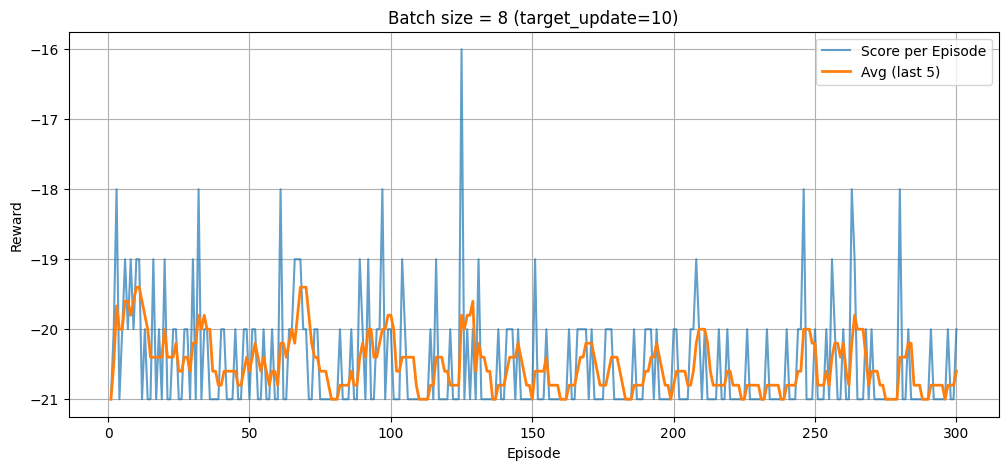

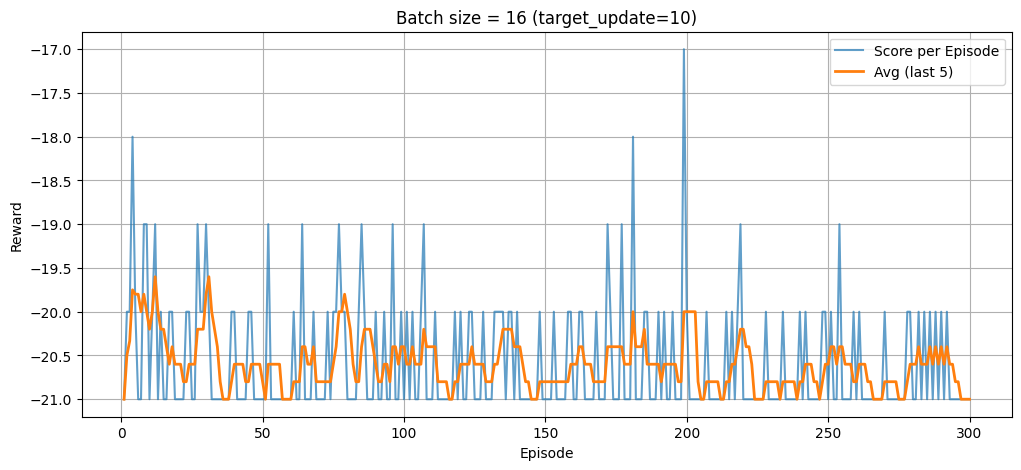

In [14]:
# Batch comparison
env_id = "ALE/Pong-v5"   # or "ALE/Pong-v5" if gymnasium resolves that.
df_bs8 = train_dqn(env_id, num_episodes=300, batch_size=8, target_update_episodes=10, save_dir="./runs")
df_bs16 = train_dqn(env_id, num_episodes=300, batch_size=16, target_update_episodes=10, save_dir="./runs")

plot_training(df_bs8, "Batch size = 8 (target_update=10)")
plot_training(df_bs16, "Batch size = 16 (target_update=10)")

### Step 12: Compare Training with Different Target Network Update Intervals

Here, the DQN agent is trained with different target network update frequencies —  
one model updates the target network every **3 episodes**, and another every **10 episodes**.  

This comparison helps understand how frequently updating the target network influences learning stability and performance.  
The training results for both configurations are visualized for comparison.


Episodes:   0%|          | 1/300 [00:05<25:25,  5.10s/it]

Ep 1/300 | Score: -19.0 | Avg5: -19.00 | Eps: 0.995 | Steps: 980 | Loss: 0.019181576643727355


Episodes:   3%|▎         | 10/300 [00:48<23:56,  4.95s/it]

Ep 10/300 | Score: -20.0 | Avg5: -20.40 | Eps: 0.951 | Steps: 1068 | Loss: 0.019721705116969954


Episodes:   7%|▋         | 20/300 [01:33<20:30,  4.40s/it]

Ep 20/300 | Score: -21.0 | Avg5: -20.40 | Eps: 0.905 | Steps: 813 | Loss: 0.023060678755709853


Episodes:  10%|█         | 30/300 [02:20<22:16,  4.95s/it]

Ep 30/300 | Score: -20.0 | Avg5: -20.20 | Eps: 0.860 | Steps: 1079 | Loss: 0.022300499985430412


Episodes:  13%|█▎        | 40/300 [03:09<20:32,  4.74s/it]

Ep 40/300 | Score: -20.0 | Avg5: -20.20 | Eps: 0.818 | Steps: 904 | Loss: 0.022237480617488183


Episodes:  17%|█▋        | 50/300 [03:58<20:56,  5.03s/it]

Ep 50/300 | Score: -20.0 | Avg5: -19.40 | Eps: 0.778 | Steps: 933 | Loss: 0.02353548250212706


Episodes:  20%|██        | 60/300 [04:44<18:26,  4.61s/it]

Ep 60/300 | Score: -21.0 | Avg5: -20.60 | Eps: 0.740 | Steps: 900 | Loss: 0.02329106338626136


Episodes:  23%|██▎       | 70/300 [05:31<18:50,  4.91s/it]

Ep 70/300 | Score: -20.0 | Avg5: -20.80 | Eps: 0.704 | Steps: 1108 | Loss: 0.02499995868428634


Episodes:  27%|██▋       | 80/300 [06:19<18:44,  5.11s/it]

Ep 80/300 | Score: -19.0 | Avg5: -20.20 | Eps: 0.670 | Steps: 1091 | Loss: 0.02420705880151441


Episodes:  30%|███       | 90/300 [07:04<15:50,  4.53s/it]

Ep 90/300 | Score: -21.0 | Avg5: -20.60 | Eps: 0.637 | Steps: 854 | Loss: 0.023784888977618653


Episodes:  33%|███▎      | 100/300 [07:50<15:00,  4.50s/it]

Ep 100/300 | Score: -21.0 | Avg5: -20.80 | Eps: 0.606 | Steps: 884 | Loss: 0.01941041237132924


Episodes:  37%|███▋      | 110/300 [08:34<14:26,  4.56s/it]

Ep 110/300 | Score: -20.0 | Avg5: -20.80 | Eps: 0.576 | Steps: 894 | Loss: 0.02331320799720045


Episodes:  40%|████      | 120/300 [09:21<14:15,  4.75s/it]

Ep 120/300 | Score: -20.0 | Avg5: -20.80 | Eps: 0.548 | Steps: 934 | Loss: 0.0247665912327227


Episodes:  43%|████▎     | 130/300 [10:07<13:02,  4.60s/it]

Ep 130/300 | Score: -21.0 | Avg5: -20.60 | Eps: 0.521 | Steps: 852 | Loss: 0.026035850380498566


Episodes:  47%|████▋     | 140/300 [10:54<13:08,  4.93s/it]

Ep 140/300 | Score: -19.0 | Avg5: -20.40 | Eps: 0.496 | Steps: 981 | Loss: 0.0234029788706694


Episodes:  50%|█████     | 150/300 [11:42<12:15,  4.90s/it]

Ep 150/300 | Score: -20.0 | Avg5: -20.40 | Eps: 0.471 | Steps: 898 | Loss: 0.022758859365233836


Episodes:  53%|█████▎    | 160/300 [12:26<10:03,  4.31s/it]

Ep 160/300 | Score: -21.0 | Avg5: -20.60 | Eps: 0.448 | Steps: 764 | Loss: 0.02510907470108987


Episodes:  57%|█████▋    | 170/300 [13:10<09:52,  4.56s/it]

Ep 170/300 | Score: -21.0 | Avg5: -20.60 | Eps: 0.427 | Steps: 764 | Loss: 0.01926141111355514


Episodes:  60%|██████    | 180/300 [13:55<09:12,  4.60s/it]

Ep 180/300 | Score: -19.0 | Avg5: -20.40 | Eps: 0.406 | Steps: 937 | Loss: 0.02457107114058938


Episodes:  63%|██████▎   | 190/300 [14:39<08:18,  4.53s/it]

Ep 190/300 | Score: -21.0 | Avg5: -20.80 | Eps: 0.386 | Steps: 824 | Loss: 0.025451851918951787


Episodes:  67%|██████▋   | 200/300 [15:25<07:18,  4.39s/it]

Ep 200/300 | Score: -21.0 | Avg5: -21.00 | Eps: 0.367 | Steps: 764 | Loss: 0.025891768851369883


Episodes:  70%|███████   | 210/300 [16:12<07:05,  4.73s/it]

Ep 210/300 | Score: -20.0 | Avg5: -20.60 | Eps: 0.349 | Steps: 898 | Loss: 0.025459991938436552


Episodes:  73%|███████▎  | 220/300 [16:57<05:55,  4.44s/it]

Ep 220/300 | Score: -21.0 | Avg5: -20.80 | Eps: 0.332 | Steps: 824 | Loss: 0.027141838758731503


Episodes:  77%|███████▋  | 230/300 [17:44<05:31,  4.73s/it]

Ep 230/300 | Score: -21.0 | Avg5: -20.60 | Eps: 0.316 | Steps: 824 | Loss: 0.027640516004555925


Episodes:  80%|████████  | 240/300 [18:33<04:42,  4.70s/it]

Ep 240/300 | Score: -21.0 | Avg5: -20.80 | Eps: 0.300 | Steps: 905 | Loss: 0.020588300983310236


Episodes:  83%|████████▎ | 250/300 [19:23<04:02,  4.84s/it]

Ep 250/300 | Score: -19.0 | Avg5: -20.40 | Eps: 0.286 | Steps: 948 | Loss: 0.02378593145010127


Episodes:  87%|████████▋ | 260/300 [20:10<03:25,  5.13s/it]

Ep 260/300 | Score: -20.0 | Avg5: -20.40 | Eps: 0.272 | Steps: 1007 | Loss: 0.02239139139947597


Episodes:  90%|█████████ | 270/300 [20:57<02:18,  4.61s/it]

Ep 270/300 | Score: -21.0 | Avg5: -20.60 | Eps: 0.258 | Steps: 884 | Loss: 0.022583444028793455


Episodes:  93%|█████████▎| 280/300 [21:40<01:29,  4.47s/it]

Ep 280/300 | Score: -20.0 | Avg5: -20.80 | Eps: 0.246 | Steps: 838 | Loss: 0.02700063683449828


Episodes:  97%|█████████▋| 290/300 [22:28<00:47,  4.78s/it]

Ep 290/300 | Score: -21.0 | Avg5: -20.00 | Eps: 0.234 | Steps: 824 | Loss: 0.023820944310288715


Episodes: 100%|██████████| 300/300 [23:13<00:00,  4.64s/it]

Ep 300/300 | Score: -21.0 | Avg5: -20.80 | Eps: 0.222 | Steps: 764 | Loss: 0.023626591610881934



Episodes:   0%|          | 1/300 [00:06<30:25,  6.11s/it]

Ep 1/300 | Score: -20.0 | Avg5: -20.00 | Eps: 0.995 | Steps: 1207 | Loss: 0.01146549130212328


Episodes:   3%|▎         | 10/300 [00:47<22:11,  4.59s/it]

Ep 10/300 | Score: -21.0 | Avg5: -19.80 | Eps: 0.951 | Steps: 764 | Loss: 0.024186856140969777


Episodes:   7%|▋         | 20/300 [01:33<21:03,  4.51s/it]

Ep 20/300 | Score: -21.0 | Avg5: -20.20 | Eps: 0.905 | Steps: 826 | Loss: 0.023650072407756524


Episodes:  10%|█         | 30/300 [02:23<22:16,  4.95s/it]

Ep 30/300 | Score: -21.0 | Avg5: -20.40 | Eps: 0.860 | Steps: 973 | Loss: 0.021478711691194953


Episodes:  13%|█▎        | 40/300 [03:12<21:28,  4.96s/it]

Ep 40/300 | Score: -20.0 | Avg5: -20.00 | Eps: 0.818 | Steps: 992 | Loss: 0.023349137847470693


Episodes:  17%|█▋        | 50/300 [03:58<18:54,  4.54s/it]

Ep 50/300 | Score: -21.0 | Avg5: -20.60 | Eps: 0.778 | Steps: 853 | Loss: 0.024595280044313887


Episodes:  20%|██        | 60/300 [04:46<17:59,  4.50s/it]

Ep 60/300 | Score: -21.0 | Avg5: -20.80 | Eps: 0.740 | Steps: 824 | Loss: 0.022677439649837167


Episodes:  23%|██▎       | 70/300 [05:28<16:06,  4.20s/it]

Ep 70/300 | Score: -21.0 | Avg5: -21.00 | Eps: 0.704 | Steps: 811 | Loss: 0.023483251648597332


Episodes:  27%|██▋       | 80/300 [06:14<16:42,  4.56s/it]

Ep 80/300 | Score: -21.0 | Avg5: -20.40 | Eps: 0.670 | Steps: 826 | Loss: 0.024281538847630076


Episodes:  30%|███       | 90/300 [06:57<15:20,  4.38s/it]

Ep 90/300 | Score: -20.0 | Avg5: -20.60 | Eps: 0.637 | Steps: 842 | Loss: 0.024389059151906627


Episodes:  33%|███▎      | 100/300 [07:41<15:01,  4.51s/it]

Ep 100/300 | Score: -21.0 | Avg5: -21.00 | Eps: 0.606 | Steps: 961 | Loss: 0.02398762278910896


Episodes:  37%|███▋      | 110/300 [08:28<14:41,  4.64s/it]

Ep 110/300 | Score: -20.0 | Avg5: -20.60 | Eps: 0.576 | Steps: 879 | Loss: 0.026713731090259547


Episodes:  40%|████      | 120/300 [09:14<13:17,  4.43s/it]

Ep 120/300 | Score: -21.0 | Avg5: -20.80 | Eps: 0.548 | Steps: 764 | Loss: 0.0247708815263864


Episodes:  43%|████▎     | 130/300 [10:00<13:07,  4.63s/it]

Ep 130/300 | Score: -21.0 | Avg5: -20.40 | Eps: 0.521 | Steps: 852 | Loss: 0.023218996955235948


Episodes:  47%|████▋     | 140/300 [10:42<11:22,  4.27s/it]

Ep 140/300 | Score: -21.0 | Avg5: -21.00 | Eps: 0.496 | Steps: 884 | Loss: 0.024202712705847174


Episodes:  50%|█████     | 150/300 [11:27<11:01,  4.41s/it]

Ep 150/300 | Score: -21.0 | Avg5: -20.80 | Eps: 0.471 | Steps: 764 | Loss: 0.023824121987877454


Episodes:  53%|█████▎    | 160/300 [12:11<10:31,  4.51s/it]

Ep 160/300 | Score: -20.0 | Avg5: -20.20 | Eps: 0.448 | Steps: 843 | Loss: 0.026261709329991438


Episodes:  57%|█████▋    | 170/300 [12:57<10:20,  4.77s/it]

Ep 170/300 | Score: -21.0 | Avg5: -20.60 | Eps: 0.427 | Steps: 854 | Loss: 0.023629790830991773


Episodes:  60%|██████    | 180/300 [13:43<09:18,  4.65s/it]

Ep 180/300 | Score: -21.0 | Avg5: -20.80 | Eps: 0.406 | Steps: 880 | Loss: 0.02256890237261938


Episodes:  63%|██████▎   | 190/300 [14:29<08:37,  4.70s/it]

Ep 190/300 | Score: -21.0 | Avg5: -20.00 | Eps: 0.386 | Steps: 764 | Loss: 0.025185246837024604


Episodes:  67%|██████▋   | 200/300 [15:20<09:27,  5.68s/it]

Ep 200/300 | Score: -18.0 | Avg5: -19.40 | Eps: 0.367 | Steps: 1252 | Loss: 0.024363248204074955


Episodes:  70%|███████   | 210/300 [16:08<07:44,  5.16s/it]

Ep 210/300 | Score: -19.0 | Avg5: -20.00 | Eps: 0.349 | Steps: 980 | Loss: 0.024890468072319018


Episodes:  73%|███████▎  | 220/300 [16:55<06:18,  4.73s/it]

Ep 220/300 | Score: -21.0 | Avg5: -20.20 | Eps: 0.332 | Steps: 783 | Loss: 0.02274900663867911


Episodes:  77%|███████▋  | 230/300 [17:40<05:12,  4.47s/it]

Ep 230/300 | Score: -21.0 | Avg5: -21.00 | Eps: 0.316 | Steps: 824 | Loss: 0.021274105079198122


Episodes:  80%|████████  | 240/300 [18:27<04:42,  4.71s/it]

Ep 240/300 | Score: -21.0 | Avg5: -20.60 | Eps: 0.300 | Steps: 854 | Loss: 0.024228223661075028


Episodes:  83%|████████▎ | 250/300 [19:12<03:45,  4.51s/it]

Ep 250/300 | Score: -21.0 | Avg5: -20.80 | Eps: 0.286 | Steps: 824 | Loss: 0.023871932193976392


Episodes:  87%|████████▋ | 260/300 [19:57<02:51,  4.30s/it]

Ep 260/300 | Score: -21.0 | Avg5: -21.00 | Eps: 0.272 | Steps: 792 | Loss: 0.02431807062711956


Episodes:  90%|█████████ | 270/300 [20:42<02:14,  4.47s/it]

Ep 270/300 | Score: -20.0 | Avg5: -20.60 | Eps: 0.258 | Steps: 837 | Loss: 0.023988878724000164


Episodes:  93%|█████████▎| 280/300 [21:26<01:29,  4.49s/it]

Ep 280/300 | Score: -20.0 | Avg5: -20.80 | Eps: 0.246 | Steps: 871 | Loss: 0.021879054641914603


Episodes:  97%|█████████▋| 290/300 [22:10<00:43,  4.37s/it]

Ep 290/300 | Score: -20.0 | Avg5: -20.60 | Eps: 0.234 | Steps: 838 | Loss: 0.024477199600282377


Episodes: 100%|██████████| 300/300 [22:54<00:00,  4.58s/it]

Ep 300/300 | Score: -21.0 | Avg5: -20.80 | Eps: 0.222 | Steps: 820 | Loss: 0.025273302126293945


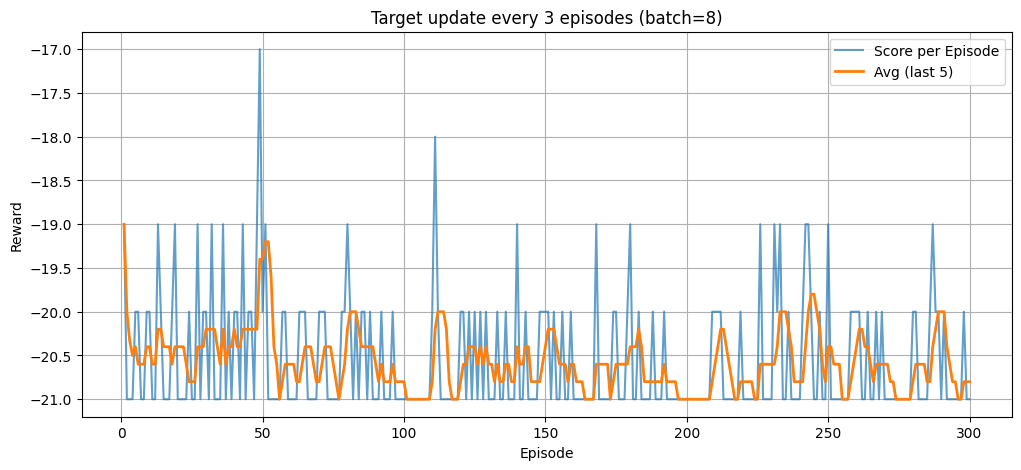

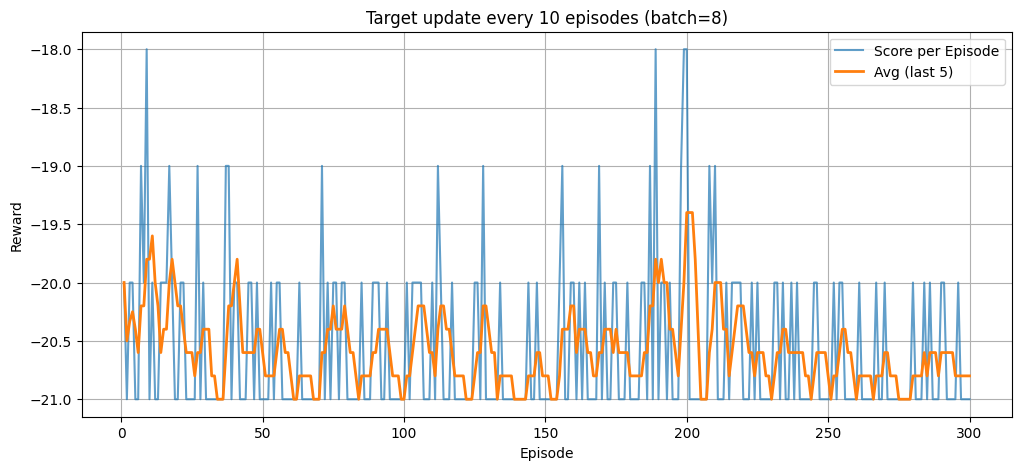

In [15]:
# Target update comparison
df_t3 = train_dqn(env_id, num_episodes=300, batch_size=8, target_update_episodes=3, save_dir="./runs")
df_t10 = train_dqn(env_id, num_episodes=300, batch_size=8, target_update_episodes=10, save_dir="./runs")

plot_training(df_t3, "Target update every 3 episodes (batch=8)")
plot_training(df_t10, "Target update every 10 episodes (batch=8)")